In [18]:
import math
import numpy as np

# create RNN architecture
learning_rate = 0.0001
seq_len = 50
max_epochs = 15
hidden_dim = 100
output_dim = 1
bptt_truncate = 5 # backprop through time --> lasts 5 iterations
min_clip_val = -10
max_clip_val = 10


def sigmoid(x):
    return 1/(1+np.exp(-x))

def calculate_loss(X, Y, U, V, W):
    loss = 0.0
    for i in range(Y.shape[0]):
        x, y = X[i], Y[i]
        prev_activation = np.zeros((hidden_dim, 1)) # value of previous activation
        for timestep in range(seq_len):
            new_input = np.zeros(x.shape) # forward pass, done for each step in the sequence
            new_input[timestep] = x[timestep] # define a single input for that timestep
            mulu = np.dot(U, new_input)
            mulw = np.dot(W, prev_activation)
            _sum = mulu + mulw
            activation = sigmoid(_sum)
            mulv = np.dot(V, activation)
            prev_activation = activation
        # calculate and add loss per record
        loss_per_record = float((y - mulv)**2/2)
        loss += loss_per_record
    # calculate loss after first Y pass
    return loss, activation

# takes x values and the weights matrices
# returns layer dictionary, final weights (mulu, mulw, mulv)
def calc_layers(x, U, V, W, prev_activation):
    layers = []
    for timestep in range(seq_len):
        new_input = np.zeros(x.shape)
        new_input[timestep] = x[timestep]
        mulu = np.dot(U, new_input)
        mulw = np.dot(W, prev_activation)
        _sum = mulw + mulu
        activation = sigmoid(_sum)
        mulv = np.dot(V, activation)
        layers.append({'activation': activation, 'prev_activation': prev_activation})
        prev_activation = activation

    return layers, mulu, mulw, mulv




def backprop(x, U, V, W, dmulv, mulu, mulw, layers):
    dU = np.zeros(U.shape)
    dV = np.zeros(V.shape)
    dW = np.zeros(W.shape)

    dU_t = np.zeros(U.shape)
    dV_t = np.zeros(V.shape)
    dW_t = np.zeros(W.shape)

    dU_i = np.zeros(U.shape)
    dW_i = np.zeros(W.shape)

    _sum = mulu + mulw
    dsv = np.dot(np.transpose(V), dmulv)

    def get_previous_activation_differential(_sum, ds, W):
        d_sum = _sum * (1 - _sum) * ds
        dmulw = d_sum * np.ones_like(ds)
        return np.dot(np.transpose(W), dmulw)

    for timestep in range(seq_len):
        dV_t = np.dot(dmulv, np.transpose(layers[timestep]['activation']))
        ds = dsv
        dprev_activation = get_previous_activation_differential(_sum, ds, W)

        for _ in range(timestep-1, max(-1, timestep-bptt_truncate-1), -1):
            ds = dsv + dprev_activation
            dprev_activation = get_previous_activation_differential(_sum, ds, W)
            dW_i = np.dot(W, layers[timestep]['prev_activation'])

            new_input = np.zeros(x.shape)
            new_input[timestep] = x[timestep]
            dU_i = np.dot(U, new_input)

            dU_t += dU_i
            dW_t += dW_i

        dU += dU_t
        dV += dV_t
        dW += dW_t

        # take care of possible exploding gradients
        if dU.max() > max_clip_val:
            dU[dU > max_clip_val] = max_clip_val
        if dV.max() > max_clip_val:
            dV[dV > max_clip_val] = max_clip_val
        if dW.max() > max_clip_val:
            dW[dW > max_clip_val] = max_clip_val

        if dU.min() < min_clip_val:
            dU[dU < min_clip_val] = min_clip_val
        if dV.min() < min_clip_val:
            dV[dV < min_clip_val] = min_clip_val
        if dW.min() < min_clip_val:
            dW[dW < min_clip_val] = min_clip_val

    return dU, dV, dW



# training
def train(U, V, W, X, Y, X_validation, Y_validation):
    for epoch in range(max_epochs):
        # calculate initial loss, ie what the output is given a random set of weights
        loss, prev_activation = calculate_loss(X, Y, U, V, W)

        # check validation loss
        val_loss, _ = calculate_loss(X_validation, Y_validation, U, V, W)

        print(f'Epoch: {epoch+1}, Loss: {loss}, Validation Loss: {val_loss}')

        # train model/forward pass
        for i in range(Y.shape[0]):
            x, y = X[i], Y[i]
            layers = []
            prev_activation = np.zeros((hidden_dim, 1))

            layers, mulu, mulw, mulv = calc_layers(x, U, V, W, prev_activation)

            # difference of the prediction
            dmulv = mulv - y
            dU, dV, dW = backprop(x, U, V, W, dmulv, mulu, mulw, layers)

            # update weights
            U -= learning_rate * dU
            V -= learning_rate * dV
            W -= learning_rate * dW
    return U, V, W

#import numpy as np
import matplotlib.pyplot as plt
#import math

from sklearn.metrics import mean_squared_error

#from simple_rnn import train, hidden_dim, seq_len, sigmoid, output_dim


#sin_wave = np.array([math.sin(x/2) * 3 + 20 for x in range(200)])
#sin_wave = np.array([math.cos(x) * math.sin(x/2) + 1 for x in range(200)])
#sin_wave = np.array([math.sin(x * 3) + 5 for x in range(200)])
sin_wave = np.array([math.cos(x) * math.sin(x/2) + 1 for x in range(200)])
# training data
X = []
Y = []
num_records = len(sin_wave) - seq_len # 150

# X entries are 50 data points
# Y entries are the 51st data point
for i in range(num_records-50):
    X.append(sin_wave[i:i+seq_len])
    Y.append(sin_wave[i+seq_len])

X = np.expand_dims(np.array(X), axis=2) # 100 x 50 x 1
Y = np.expand_dims(np.array(Y), axis=1) # 100 x 1

# validation data
X_validation = []
Y_validation = []
for i in range(num_records-seq_len, num_records):
    X_validation.append(sin_wave[i:i+seq_len])
    Y_validation.append(sin_wave[i+seq_len])

X_validation = np.expand_dims(np.array(X_validation), axis=2)
Y_validation = np.expand_dims(np.array(Y_validation), axis=1)


np.random.seed(12161)
U = np.random.uniform(0, 1, (hidden_dim, seq_len)) # weights from input to hidden layer
V = np.random.uniform(0, 1, (output_dim, hidden_dim)) # weights from hidden to output layer
W = np.random.uniform(0, 1, (hidden_dim, hidden_dim)) # recurrent weights for layer (RNN weigts)




U, V, W = train(U, V, W, X, Y, X_validation, Y_validation)

Epoch: 1, Loss: 127131.22673162923, Validation Loss: 63567.75276473399
Epoch: 2, Loss: 81709.27052824851, Validation Loss: 40856.352949894135
Epoch: 3, Loss: 46287.31432476292, Validation Loss: 23144.953135001848
Epoch: 4, Loss: 20865.356978359378, Validation Loss: 10433.552748286778
Epoch: 5, Loss: 5436.205072765665, Validation Loss: 2718.5524856394873
Epoch: 6, Loss: 21.42500345538172, Validation Loss: 10.74901628326567
Epoch: 7, Loss: 11.471874079144088, Validation Loss: 5.759682568382309
Epoch: 8, Loss: 11.487125156687664, Validation Loss: 5.768102022850443
Epoch: 9, Loss: 11.431611002720706, Validation Loss: 5.7401473033595165
Epoch: 10, Loss: 12.62667897496518, Validation Loss: 6.343113181554086
Epoch: 11, Loss: 11.471995724505662, Validation Loss: 5.760480692337439
Epoch: 12, Loss: 11.384185692900122, Validation Loss: 5.715558159531873
Epoch: 13, Loss: 11.897274054955375, Validation Loss: 5.9755918354015645
Epoch: 14, Loss: 11.279250524311388, Validation Loss: 5.66208774421756
E

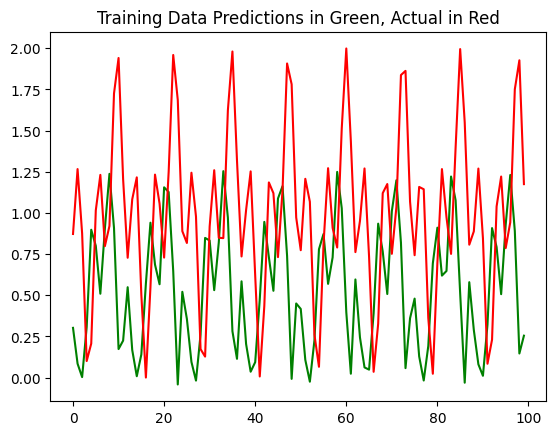

In [19]:
predictions = []
for i in range(Y.shape[0]):
    x, y = X[i], Y[i]
    prev_activation = np.zeros((hidden_dim,1))
    # forward pass
    for timestep in range(seq_len):
        mulu = np.dot(U, x)
        mulw = np.dot(W, prev_activation)
        _sum = mulu + mulw
        activation = sigmoid(_sum)
        mulv = np.dot(V, activation)
        prev_activation = activation
    predictions.append(mulv)

predictions = np.array(predictions)

plt.plot(predictions[:, 0,0], 'g')
plt.plot(Y[:, 0], 'r')
plt.title("Training Data Predictions in Green, Actual in Red")
plt.show()

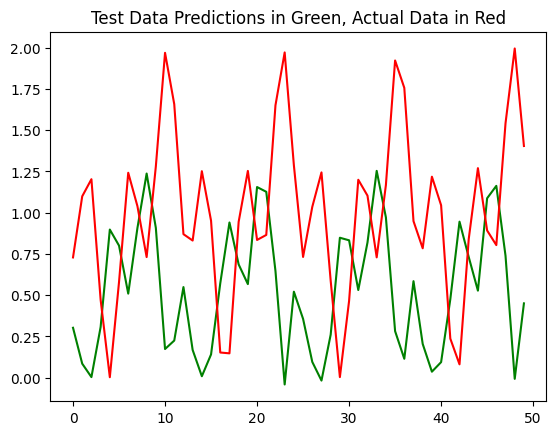

In [20]:
val_predictions = []
for i in range(Y_validation.shape[0]):
    x, y = X[i], Y[i]
    prev_activation = np.zeros((hidden_dim,1))
    # forward pass
    for timestep in range(seq_len):
        mulu = np.dot(U, x)
        mulw = np.dot(W, prev_activation)
        _sum = mulu + mulw
        activation = sigmoid(_sum)
        mulv = np.dot(V, activation)
        prev_activation = activation
    val_predictions.append(mulv)

val_predictions = np.array(val_predictions)

plt.plot(val_predictions[:, 0,0], 'g')
plt.plot(Y_validation[:, 0], 'r')
plt.title("Test Data Predictions in Green, Actual Data in Red")
plt.show()

In [21]:
# check RMSE
rmse = math.sqrt(mean_squared_error(Y_validation[:,0], val_predictions[:, 0, 0]))
print(rmse)

0.8873384449536208
